In [1]:
from download import download

dataset_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/intermediate/Canidae_data.zip"

download(dataset_url, "./datasets-Canidae", kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 11.9M/11.9M [00:05<00:00, 2.04MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./datasets-Canidae


'./datasets-Canidae'

In [1]:
batch_size = 18                             # Batch size
image_size = 224                            # Size of training image space
num_epochs = 10                             # Number of training cycles
lr = 0.001                                  # Learning rate
momentum = 0.9                              # momentum
workers = 4                                 # Number of parallel threads

In [2]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision

# Dataset directory path
data_path_train = "./datasets-Canidae/data/Canidae/train/"
data_path_val = "./datasets-Canidae/data/Canidae/val/"

# Create training dataset

def create_dataset_canidae(dataset_path, usage):
    """Data Loading"""
    data_set = ds.ImageFolderDataset(dataset_path,
                                     num_parallel_workers=workers,
                                     shuffle=True,)

    # Data transform operations
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    scale = 32

    if usage == "train":
        # Define map operations for training dataset
        trans = [
            vision.RandomCropDecodeResize(size=image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            vision.RandomHorizontalFlip(prob=0.5),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]
    else:
        # Define map operations for inference dataset
        trans = [
            vision.Decode(),
            vision.Resize(image_size + scale),
            vision.CenterCrop(image_size),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]


    # Data mapping operations
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)


    # Batch operation
    data_set = data_set.batch(batch_size, drop_remainder=True)

    return data_set


dataset_train = create_dataset_canidae(data_path_train, "train")
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_canidae(data_path_val, "val")
step_size_val = dataset_val.get_dataset_size()

In [3]:
data = next(dataset_train.create_dict_iterator())
images = data["image"]
labels = data["label"]

print("Tensor of image", images.shape)
print("Labels:", labels)

Tensor of image (18, 3, 224, 224)
Labels: [1 1 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0]


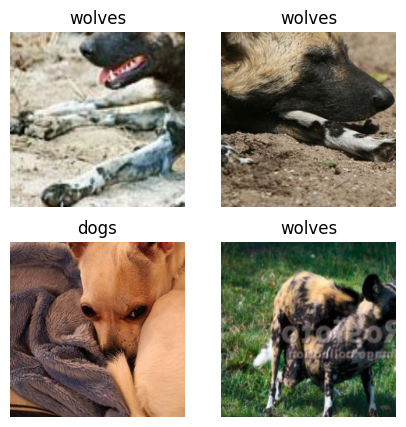

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# class_name corresponds to label, and labels are marked in order from smallest to largest folder strings.
class_name = {0: "dogs", 1: "wolves"}

plt.figure(figsize=(5, 5))
for i in range(4):
    # Get the image and its corresponding label
    data_image = images[i].asnumpy()
    data_label = labels[i]
    # Processing images for display
    data_image = np.transpose(data_image, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data_image = std * data_image + mean
    data_image = np.clip(data_image, 0, 1)
    # Display image
    plt.subplot(2, 2, i+1)
    plt.imshow(data_image)
    plt.title(class_name[int(labels[i].asnumpy())])
    plt.axis("off")

plt.show()

In [5]:
from typing import Type, Union, List, Optional
from mindspore import nn, ops, train
from mindspore.common.initializer import Normal


weight_init = Normal(mean=0, sigma=0.02)
gamma_init = Normal(mean=1, sigma=0.02)

In [6]:
class ResidualBlockBase(nn.Cell):
    expansion: int = 1  # The number of last convolutional kernels is equal to the number of first convolutional kernels

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            self.norm = nn.BatchNorm2d(out_channel)
        else:
            self.norm = norm

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.conv2 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, weight_init=weight_init)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        """ResidualBlockBase construct."""
        identity = x  # shortcuts

        out = self.conv1(x)  # The first layer of main body: 3*3 convolutional layer
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv2(out)  # The second layer of main body: 3*3 convolutional layer
        out = self.norm(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)
        out += identity  # The output is the sum of the main body and the shortcuts
        out = self.relu(out)

        return out

In [7]:
class ResidualBlock(nn.Cell):
    expansion = 4  # The number of last convolutional kernels is 4 times the number of first convolutional kernels

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=1, weight_init=weight_init)
        self.norm1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.norm2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(out_channel, out_channel * self.expansion,
                               kernel_size=1, weight_init=weight_init)
        self.norm3 = nn.BatchNorm2d(out_channel * self.expansion)

        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):

        identity = x  # shortscuts

        out = self.conv1(x)  # The first layer of main body: 1*1 convolutional layer
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)  # The second layer of main body: 3*3 convolutional layer
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv3(out)  # The third layer of main body: 3*3 convolutional layer
        out = self.norm3(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)

        out += identity  # The output is the sum of the main body and the shortcuts
        out = self.relu(out)

        return out

In [8]:
def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],
               channel: int, block_nums: int, stride: int = 1):
    down_sample = None  # shortcuts


    if stride != 1 or last_out_channel != channel * block.expansion:

        down_sample = nn.SequentialCell([
            nn.Conv2d(last_out_channel, channel * block.expansion,
                      kernel_size=1, stride=stride, weight_init=weight_init),
            nn.BatchNorm2d(channel * block.expansion, gamma_init=gamma_init)
        ])

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample))

    in_channel = channel * block.expansion
    # Stacked residual network
    for _ in range(1, block_nums):

        layers.append(block(in_channel, channel))

    return nn.SequentialCell(layers)

In [9]:
from mindspore import load_checkpoint, load_param_into_net


class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], num_classes: int, input_channel: int) -> None:
        super(ResNet, self).__init__()

        self.relu = nn.ReLU()
        # The first convolutional layer, with the number of input channel is 3 (color image) and the number of output channel is 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, weight_init=weight_init)
        self.norm = nn.BatchNorm2d(64)
        # Max pooling layer to reduce the size of the image
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # Definitions of each residual network structure block
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)
        # Average pooling layer
        self.avg_pool = nn.AvgPool2d()
        # flattern layer
        self.flatten = nn.Flatten()
        # Fully-connected layer
        self.fc = nn.Dense(in_channels=input_channel, out_channels=num_classes)

    def construct(self, x):

        x = self.conv1(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x


def _resnet(model_url: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, pretrianed_ckpt: str,
            input_channel: int):
    model = ResNet(block, layers, num_classes, input_channel)

    if pretrained:
        # Load pre-trained models
        download(url=model_url, path=pretrianed_ckpt)
        param_dict = load_checkpoint(pretrianed_ckpt)
        load_param_into_net(model, param_dict)

    return model


def resnet50(num_classes: int = 1000, pretrained: bool = False):
    "ResNet50 model"
    resnet50_url = "https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/models/application/resnet50_224_new.ckpt"
    resnet50_ckpt = "./LoadPretrainedModel/resnet50_224_new.ckpt"
    return _resnet(resnet50_url, ResidualBlock, [3, 4, 6, 3], num_classes,
                   pretrained, resnet50_ckpt, 2048)

In [16]:
from download import download
import mindspore as ms

network = resnet50(pretrained=True)
print(network.cells_and_names)

# Size of fully-connected layer input layer
in_channels = network.fc.in_channels
# The output channel number size is 2, same as the number of wolfdog classification
head = nn.Dense(in_channels, 2)
# Reset fully-connected layer
network.fc = head

# Average pooling layer kernel size is 7
avg_pool = nn.AvgPool2d(kernel_size=7)
# Reset the average pooling layer
network.avg_pool = avg_pool

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
<bound method Cell.cells_and_names of ResNet<
  (relu): ReLU<>
  (conv1): Conv2d<input_channels=3, output_channels=64, kernel_size=(7, 7), stride=(2, 2), pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.Normal object at 0x7fd4bc65a4f0>, bias_init=zeros, format=NCHW>
  (norm): BatchNorm2d<num_features=64, eps=1e-05, momentum=0.9, gamma=Parameter (name=norm.gamma, shape=(64,), dtype=Float32, requires_grad=True), beta=Parameter (name=norm.beta, shape=(64,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=norm.moving_mean, shape=(64,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=norm.moving_variance, shape=(64,), dtype=Float32, requires_grad=False)>
  (max_pool): MaxPool2d<kernel_size=3, stride=2, pad_mode=SAME>
  (layer1): SequentialCell<
    (0): ResidualBlock<
      (conv1): Conv2d<input_channe

In [47]:
# freeze params
for name, param in network.parameters_dict().items():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False
    else:
        param.requires_grad = True

In [48]:
network.parameters_dict()

OrderedDict([('conv1.weight',
              Parameter (name=conv1.weight, shape=(64, 3, 7, 7), dtype=Float32, requires_grad=False)),
             ('norm.moving_mean',
              Parameter (name=norm.moving_mean, shape=(64,), dtype=Float32, requires_grad=False)),
             ('norm.moving_variance',
              Parameter (name=norm.moving_variance, shape=(64,), dtype=Float32, requires_grad=False)),
             ('norm.gamma',
              Parameter (name=norm.gamma, shape=(64,), dtype=Float32, requires_grad=False)),
             ('norm.beta',
              Parameter (name=norm.beta, shape=(64,), dtype=Float32, requires_grad=False)),
             ('layer1.0.conv1.weight',
              Parameter (name=layer1.0.conv1.weight, shape=(64, 64, 1, 1), dtype=Float32, requires_grad=False)),
             ('layer1.0.norm1.moving_mean',
              Parameter (name=layer1.0.norm1.moving_mean, shape=(64,), dtype=Float32, requires_grad=False)),
             ('layer1.0.norm1.moving_variance',


In [49]:
from mindspore import ops

# Define optimizer and loss function
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=momentum)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# Instantiate models
model = ms.Model(network, loss_fn, opt, metrics={"Accuracy": train.Accuracy()})

def forward_fn(inputs, targets):

    logits = network(inputs)
    loss = loss_fn(logits, targets)

    return loss

grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters)

def train_step(inputs, targets):

    loss, grads = grad_fn(inputs, targets)
    opt(grads)

    return loss

In [50]:
# Create the iterator
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)

# Optimal model save path
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/resnet50-best.ckpt"

In [51]:
import os
import time

# Start circuit training
print("Start Training Loop ...")

best_acc = 0

for epoch in range(num_epochs):
    losses = []
    network.set_train()

    epoch_start = time.time()

    # Reads in data for each training round
    for i, (images, labels) in enumerate(data_loader_train):
        labels = labels.astype(ms.int32)
        loss = train_step(images, labels)
        losses.append(loss)

    # Verify the accuracy after each epoch

    acc = model.eval(dataset_val)['Accuracy']

    epoch_end = time.time()
    epoch_seconds = (epoch_end - epoch_start) * 1000
    step_seconds = epoch_seconds/step_size_train

    print("-" * 20)
    print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
        epoch+1, num_epochs, sum(losses)/len(losses), acc
    ))
    print("epoch time: %5.3f ms, per step time: %5.3f ms" % (
        epoch_seconds, step_seconds
    ))

    if acc > best_acc:
        best_acc = acc
        if not os.path.exists(best_ckpt_dir):
            os.mkdir(best_ckpt_dir)
        ms.save_checkpoint(network, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)

Start Training Loop ...
--------------------
Epoch: [  1/ 10], Average Train Loss: [0.645], Accuracy: [0.944]
epoch time: 156106.893 ms, per step time: 12008.223 ms


[WARNING] MD(26559,7fd3c5ffa700,python):2023-04-26-13:41:44.736.925 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 85.718%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd366ff4700,python):2023-04-26-13:41:55.536.180 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 86.0315%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  2/ 10], Average Train Loss: [0.390], Accuracy: [1.000]
epoch time: 166555.239 ms, per step time: 12811.941 ms


[WARNING] MD(26559,7fd3c5ffa700,python):2023-04-26-13:44:22.660.577 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 85.1404%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd366ff4700,python):2023-04-26-13:44:32.211.192 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 85.8699%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  3/ 10], Average Train Loss: [0.275], Accuracy: [0.981]
epoch time: 145696.490 ms, per step time: 11207.422 ms


[WARNING] MD(26559,7fd3c5ffa700,python):2023-04-26-13:46:45.626.393 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 85.7646%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd366ff4700,python):2023-04-26-13:46:55.276.081 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 86.3892%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  4/ 10], Average Train Loss: [0.212], Accuracy: [1.000]
epoch time: 143442.586 ms, per step time: 11034.045 ms


[WARNING] MD(26559,7fd3c5ffa700,python):2023-04-26-13:49:04.214.057 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 86.431%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd366ff4700,python):2023-04-26-13:49:14.172.529 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 86.9296%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  5/ 10], Average Train Loss: [0.153], Accuracy: [1.000]
epoch time: 137211.749 ms, per step time: 10554.750 ms


[WARNING] MD(26559,7fd3c5ffa700,python):2023-04-26-13:51:22.576.806 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 87.1469%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd366ff4700,python):2023-04-26-13:51:31.563.527 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 87.4054%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  6/ 10], Average Train Loss: [0.146], Accuracy: [1.000]
epoch time: 137446.847 ms, per step time: 10572.834 ms


[WARNING] MD(26559,7fd3c5ffa700,python):2023-04-26-13:53:36.975.840 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 87.5688%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd366ff4700,python):2023-04-26-13:53:46.034.214 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 87.6483%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  7/ 10], Average Train Loss: [0.161], Accuracy: [1.000]
epoch time: 134767.245 ms, per step time: 10366.711 ms


[WARNING] MD(26559,7fd3c5ffa700,python):2023-04-26-13:55:59.592.839 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 87.5918%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd366ff4700,python):2023-04-26-13:56:08.610.066 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 87.7365%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  8/ 10], Average Train Loss: [0.187], Accuracy: [1.000]
epoch time: 141721.268 ms, per step time: 10901.636 ms


[WARNING] MD(26559,7fd366ff4700,python):2023-04-26-13:58:23.460.529 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 86.4161%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  9/ 10], Average Train Loss: [0.127], Accuracy: [1.000]
epoch time: 135070.427 ms, per step time: 10390.033 ms


[WARNING] MD(26559,7fd36a7fb700,python):2023-04-26-14:00:39.130.921 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 86.3447%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [ 10/ 10], Average Train Loss: [0.157], Accuracy: [1.000]
epoch time: 134944.463 ms, per step time: 10380.343 ms
End of validation the best Accuracy is:  1.000, save the best ckpt file in ./BestCheckpoint/resnet50-best.ckpt


In [52]:
import matplotlib.pyplot as plt
import mindspore as ms

def visualize_model(best_ckpt_path, val_ds):
    net = resnet50()
    # Size of fully-connected layer input layer
    in_channels = net.fc.in_channels
    # The output channel number size is 2, same as the number of wolfdog classification
    head = nn.Dense(in_channels, 2)
    # Reset fully-connected layer
    net.fc = head
    # Average pooling layer kernel size is 7
    avg_pool = nn.AvgPool2d(kernel_size=7)
    # Reset average pooling layer
    net.avg_pool = avg_pool
    # Load model parameters
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    model = ms.Model(net)
    # Load the data from the validation set for validation
    data = next(val_ds.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    class_name = {0: "dogs", 1: "wolves"}
    # Predicted image categories
    output = model.predict(ms.Tensor(data['image']))
    pred = np.argmax(output.asnumpy(), axis=1)

    # Display images and predicted values of images
    plt.figure(figsize=(5, 5))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        # If the prediction is correct, the display is blue, and if the prediction is wrong, the display is red
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('predict:{}'.format(class_name[pred[i]]), color=color)
        picture_show = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()

[WARNING] MD(26559,7fd36a7fb700,python):2023-04-26-14:13:05.259.159 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 86.9417%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


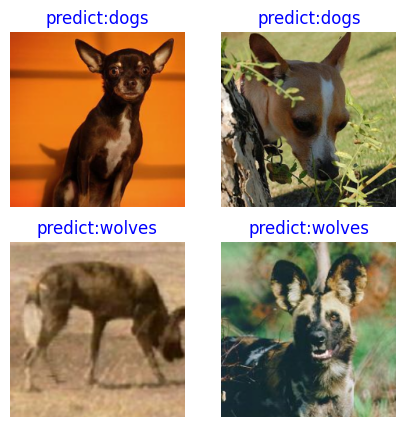

In [53]:
visualize_model(best_ckpt_path, dataset_val)

In [54]:
net_work = resnet50(pretrained=True)

# Size of fully-connected layer input layer
in_channels = net_work.fc.in_channels
# The output channel number size is 2, same as the number of wolfdog classification
head = nn.Dense(in_channels, 2)
# Reset fully-connected layer
net_work.fc = head

# Average pooling layer kernel size is 7
avg_pool = nn.AvgPool2d(kernel_size=7)
# Reset average pooling layer
net_work.avg_pool = avg_pool

# Freeze all parameters except the last layer
for param in net_work.get_parameters():
    if param.name not in ["fc.weight", "fc.bias"]:
        param.requires_grad = False

# Define optimizer and loss function
opt = nn.Momentum(params=net_work.trainable_params(), learning_rate=lr, momentum=0.5)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


def forward_fn(inputs, targets):
    logits = net_work(inputs)
    loss = loss_fn(logits, targets)

    return loss

grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters)

def train_step(inputs, targets):
    loss, grads = grad_fn(inputs, targets)
    opt(grads)
    return loss

# Instantiate models
model1 = ms.Model(net_work, loss_fn, opt, metrics={"Accuracy": train.Accuracy()})

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


In [55]:
dataset_train = create_dataset_canidae(data_path_train, "train")
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_canidae(data_path_val, "val")
step_size_val = dataset_val.get_dataset_size()

num_epochs = 10

# Creating Iterators
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/resnet50-best-freezing-param.ckpt"

In [56]:
# Start circuit training
print("Start Training Loop ...")

best_acc = 0

for epoch in range(num_epochs):
    losses = []
    net_work.set_train()

    epoch_start = time.time()

    # Read in data for each training round
    for i, (images, labels) in enumerate(data_loader_train):
        labels = labels.astype(ms.int32)
        loss = train_step(images, labels)
        losses.append(loss)

    # Verify the accuracy after each epoch

    acc = model1.eval(dataset_val)['Accuracy']

    epoch_end = time.time()
    epoch_seconds = (epoch_end - epoch_start) * 1000
    step_seconds = epoch_seconds/step_size_train

    print("-" * 20)
    print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
        epoch+1, num_epochs, sum(losses)/len(losses), acc
    ))
    print("epoch time: %5.3f ms, per step time: %5.3f ms" % (
        epoch_seconds, step_seconds
    ))

    if acc > best_acc:
        best_acc = acc
        if not os.path.exists(best_ckpt_dir):
            os.mkdir(best_ckpt_dir)
        ms.save_checkpoint(net_work, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)

Start Training Loop ...


[WARNING] MD(26559,7fd3c7ffe700,python):2023-04-26-14:16:32.431.491 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.7804%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd3c7ffe700,python):2023-04-26-14:16:33.457.518 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.8428%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd3c7ffe700,python):2023-04-26-14:18:40.673.550 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 90.4146%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map'

--------------------
Epoch: [  1/ 10], Average Train Loss: [0.651], Accuracy: [0.963]
epoch time: 169547.835 ms, per step time: 13042.141 ms


[WARNING] MD(26559,7fd3c7ffe700,python):2023-04-26-14:21:30.790.173 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.3444%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd36a7fb700,python):2023-04-26-14:21:40.904.867 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.4549%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  2/ 10], Average Train Loss: [0.553], Accuracy: [1.000]
epoch time: 163480.957 ms, per step time: 12575.458 ms


[WARNING] MD(26559,7fd3c7ffe700,python):2023-04-26-14:23:54.956.236 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.1571%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd36a7fb700,python):2023-04-26-14:24:07.254.903 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.3998%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  3/ 10], Average Train Loss: [0.481], Accuracy: [0.963]
epoch time: 145409.624 ms, per step time: 11185.356 ms


[WARNING] MD(26559,7fd3c7ffe700,python):2023-04-26-14:26:28.034.317 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.2504%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd36a7fb700,python):2023-04-26-14:26:37.403.150 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.6391%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  4/ 10], Average Train Loss: [0.438], Accuracy: [1.000]
epoch time: 149846.473 ms, per step time: 11526.652 ms


[WARNING] MD(26559,7fd3c7ffe700,python):2023-04-26-14:28:56.369.930 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.5292%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd36a7fb700,python):2023-04-26-14:29:06.314.669 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.613%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  5/ 10], Average Train Loss: [0.405], Accuracy: [1.000]
epoch time: 147619.442 ms, per step time: 11355.342 ms


[WARNING] MD(26559,7fd3c7ffe700,python):2023-04-26-14:31:17.030.352 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.4489%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd36a7fb700,python):2023-04-26-14:31:26.230.193 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.6647%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  6/ 10], Average Train Loss: [0.360], Accuracy: [1.000]
epoch time: 140343.663 ms, per step time: 10795.666 ms


[WARNING] MD(26559,7fd3c7ffe700,python):2023-04-26-14:33:35.563.059 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.8056%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd36a7fb700,python):2023-04-26-14:33:45.055.013 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.8709%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  7/ 10], Average Train Loss: [0.338], Accuracy: [1.000]
epoch time: 139240.100 ms, per step time: 10710.777 ms


[WARNING] MD(26559,7fd3c7ffe700,python):2023-04-26-14:35:56.020.847 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.5577%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(26559,7fd36a7fb700,python):2023-04-26-14:36:04.696.652 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 89.7466%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  8/ 10], Average Train Loss: [0.286], Accuracy: [1.000]
epoch time: 139531.549 ms, per step time: 10733.196 ms


[WARNING] MD(26559,7fd36a7fb700,python):2023-04-26-14:38:24.289.331 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 88.1278%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [  9/ 10], Average Train Loss: [0.298], Accuracy: [1.000]
epoch time: 139343.196 ms, per step time: 10718.707 ms


[WARNING] MD(26559,7fd36a7fb700,python):2023-04-26-14:41:06.385.653 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:136] operator()] Memory consumption is more than 86.8256%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


--------------------
Epoch: [ 10/ 10], Average Train Loss: [0.266], Accuracy: [1.000]
epoch time: 172723.354 ms, per step time: 13286.412 ms
End of validation the best Accuracy is:  1.000, save the best ckpt file in ./BestCheckpoint/resnet50-best-freezing-param.ckpt


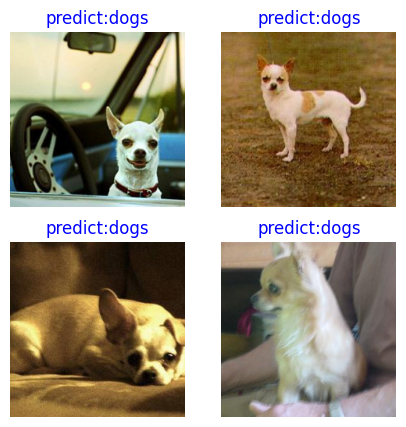

In [57]:
visualize_model(best_ckpt_path, dataset_val)